<a href="https://colab.research.google.com/github/2000Barakaza/FLASK/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
### set seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

LEARNING_RATE = 3e-4
BATCH_SIZE = 128
EPOCHS = 10
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="data",
                                 train = True,
                                 download = True,
                                 transform=transform)

test_dataset = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform=transform)

In [ ]:
print(train_dataset)
print(test_dataset)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

print(128 * 390.5)
print(50000 / 128)

In [ ]:
print(PATCH_SIZE)

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels =embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
    self.num_patches = num_patches

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x = x.flatten(2).transpose(1, 2)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embed
    return x

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.fc2 = nn.Linear(hidden_features, in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:

class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, mlp_dim, drop_rate, depth):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

In [ ]:
print(DEPTH)

In [ ]:
print(device)

In [ ]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,
    NUM_CLASSES, EMBED_DIM, NUM_HEADS,
    MLP_DIM, DROP_RATE, DEPTH
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

In [ ]:
print(criterion)

In [ ]:
print(optimizer)

In [ ]:
def train(model, loader, optimizer, criterion):
  model.train()

  total_loss, correct = 0, 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)

    loss = criterion(out, y)

    loss.backward()

    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()


  avg_loss = total_loss / len(loader.dataset)
  accuracy = correct / len(loader.dataset)
  return avg_loss, accuracy

In [ ]:
  avg_loss = total_loss / len(loader.dataset)
  accuracy = correct / len(loader.dataset)
  return avg_loss, accuracy

In [ ]:
def evaluate(model, loader):
  model.eval()

  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
  return correct / len(loader.dataset)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.4f}%, Test_acc:{test_acc:.4f} ")

print(train_accuracies)

In [ ]:
print(train_accuracies)

In [ ]:
plt.plot(train_accuracies, label="Train_accuracy")
plt.plot(test_accuracies, label="Test_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print(len(test_dataset))

In [ ]:
print(test_dataset[0][0].unsqueeze(dim=0).shape)
print(test_dataset[0][0] / 2 + 0.5)

In [ ]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output, dim=1)
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
        truth = classes[true_label] == classes[predicted.item()]
        if truth:
          color = "g"
        else:
          color = "r"

        axes[i, j].set_title(f"Truth: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", fontsize=10, c=color)
        axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)

2.8.0+cu126
0.23.0+cu126
True
cuda


100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
50000
10000
DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7d296ff16f30>, <torch.utils.data.dat

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train_loss: 1.9472, Train_acc: 0.2851%, Test_acc:0.3510 
Epoch: 2/10, Train_loss: 1.6740, Train_acc: 0.3915%, Test_acc:0.4339 
Epoch: 3/10, Train_loss: 1.5543, Train_acc: 0.4378%, Test_acc:0.4687 
Epoch: 4/10, Train_loss: 1.4744, Train_acc: 0.4681%, Test_acc:0.4912 
Epoch: 5/10, Train_loss: 1.4167, Train_acc: 0.4866%, Test_acc:0.5180 
Epoch: 6/10, Train_loss: 1.3582, Train_acc: 0.5113%, Test_acc:0.5130 
Epoch: 7/10, Train_loss: 1.3146, Train_acc: 0.5315%, Test_acc:0.5405 
Epoch: 8/10, Train_loss: 1.2618, Train_acc: 0.5488%, Test_acc:0.5648 
Epoch: 9/10, Train_loss: 1.2123, Train_acc: 0.5666%, Test_acc:0.5731 
Epoch: 10/10, Train_loss: 1.1697, Train_acc: 0.5815%, Test_acc:0.5908 
[0.28512, 0.39148, 0.43776, 0.46806, 0.48656, 0.51132, 0.53146, 0.5488, 0.56662, 0.58152]


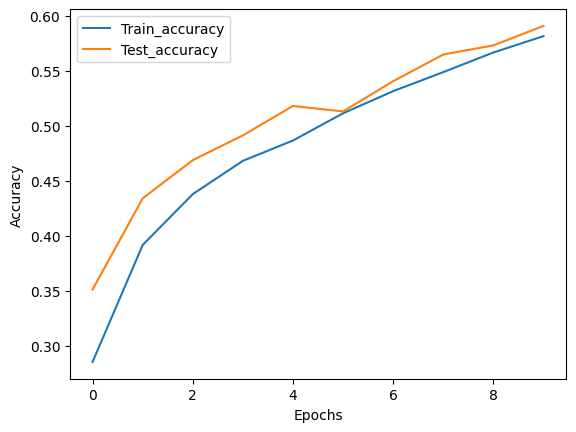

10000
torch.Size([1, 3, 32, 32])
tensor([[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.7412, 0.7451, 0.7216,  ..., 0.5294, 0.0392, 0.0392],
         ...,
         [0.1137, 0.1451, 0.1882,  ..., 0.2118, 0.0392, 0.0392],
         [0.1294, 0.1333, 0.1686,  ..., 0.2157, 0.0392, 0.0392],
         [0.1255, 0.1529, 0.1490,  ..., 0.1686, 0.0392, 0.0392]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.3294, 0.3333, 0.3059,  ..., 0.2510, 0.0392, 0.0392],
         ...,
         [0.5765, 0.5490, 0.5098,  ..., 0.5686, 0.0392, 0.0392],
         [0.5843, 0.5647, 0.5490,  ..., 0.5529, 0.0392, 0.0392],
         [0.5608, 0.5765, 0.5490,  ..., 0.5176, 0.0392, 0.0392]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.2157, 0.2275,

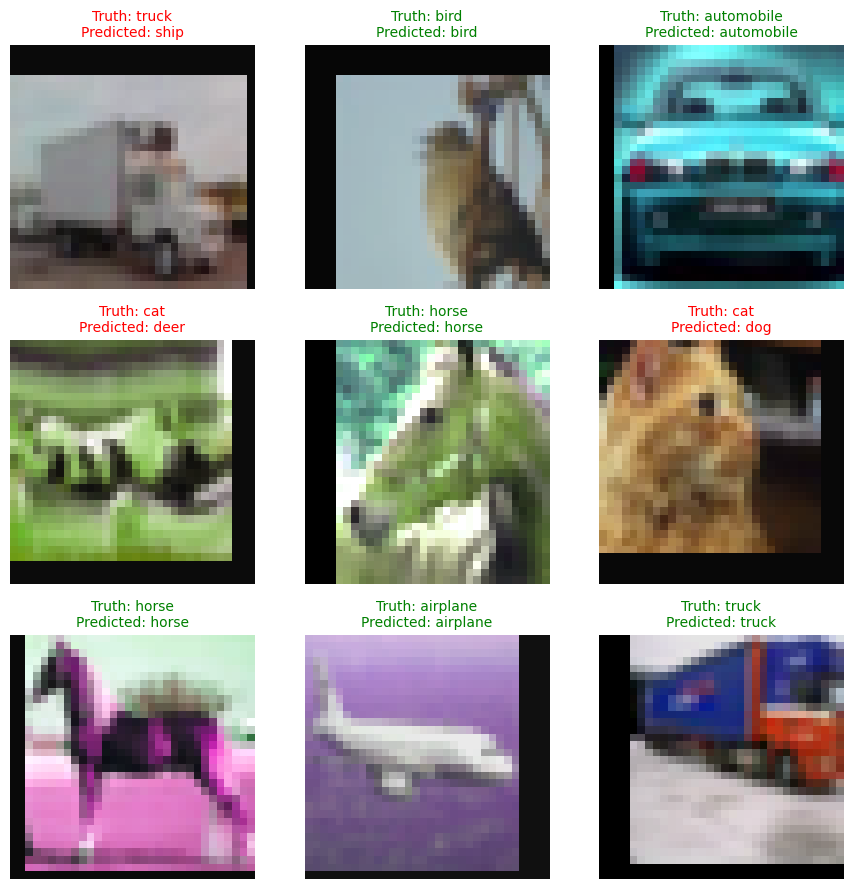

In [ ]:
!pip install torch torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

### set seed:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

LEARNING_RATE = 3e-4
BATCH_SIZE = 128
EPOCHS = 10
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="data",
                                 train = True,
                                 download = True,
                                 transform=transform)

test_dataset = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform=transform)

print(train_dataset)
print(test_dataset)

print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

print(128 * 390.5)
print(50000 / 128)

print(PATCH_SIZE)

class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels =embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
    self.num_patches = num_patches

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x = x.flatten(2).transpose(1, 2)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embed
    return x

class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.fc2 = nn.Linear(hidden_features, in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, mlp_dim, drop_rate, depth):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(*[
        TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)

print(DEPTH)

print(device)

model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS,
    NUM_CLASSES, EMBED_DIM, NUM_HEADS,
    MLP_DIM, DROP_RATE, DEPTH
).to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

print(criterion)
print(optimizer)

def train(model, loader, optimizer, criterion):
  model.train()

  total_loss, correct = 0, 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)

    loss = criterion(out, y)

    loss.backward()

    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()


  avg_loss = total_loss / len(loader.dataset)
  accuracy = correct / len(loader.dataset)
  return avg_loss, accuracy

def evaluate(model, loader):
  model.eval()

  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
  return correct / len(loader.dataset)

from tqdm.auto import tqdm

train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.4f}%, Test_acc:{test_acc:.4f} ")

print(train_accuracies)

plt.plot(train_accuracies, label="Train_accuracy")
plt.plot(test_accuracies, label="Test_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print(len(test_dataset))

print(test_dataset[0][0].unsqueeze(dim=0).shape)
print(test_dataset[0][0] / 2 + 0.5)

def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output, dim=1)
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
        truth = classes[true_label] == classes[predicted.item()]
        if truth:
          color = "g"
        else:
          color = "r"

        axes[i, j].set_title(f"Truth: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", fontsize=10, c=color)
        axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()

predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.8.0+cpu
0.23.0+cpu


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_input_dataset_dir = "./input_dataset"

img.size (28, 28)
label 0


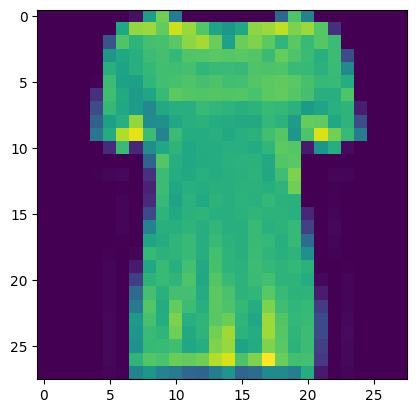

In [ ]:
fmnist = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=True)
img, label = fmnist[10]
print("img.size", img.size)
print("label", label)
plt.imshow(img)
plt.show()

In [ ]:
train_images = fmnist.data
train_img_targets = fmnist.targets

print("Train Image Shape", train_images.shape)
print("Train Image Size", train_images.size())
print("Targets Shape", train_img_targets.shape)
print("Targets Size", train_img_targets.size())

Train Image Shape torch.Size([60000, 28, 28])
Train Image Size torch.Size([60000, 28, 28])
Targets Shape torch.Size([60000])
Targets Size torch.Size([60000])


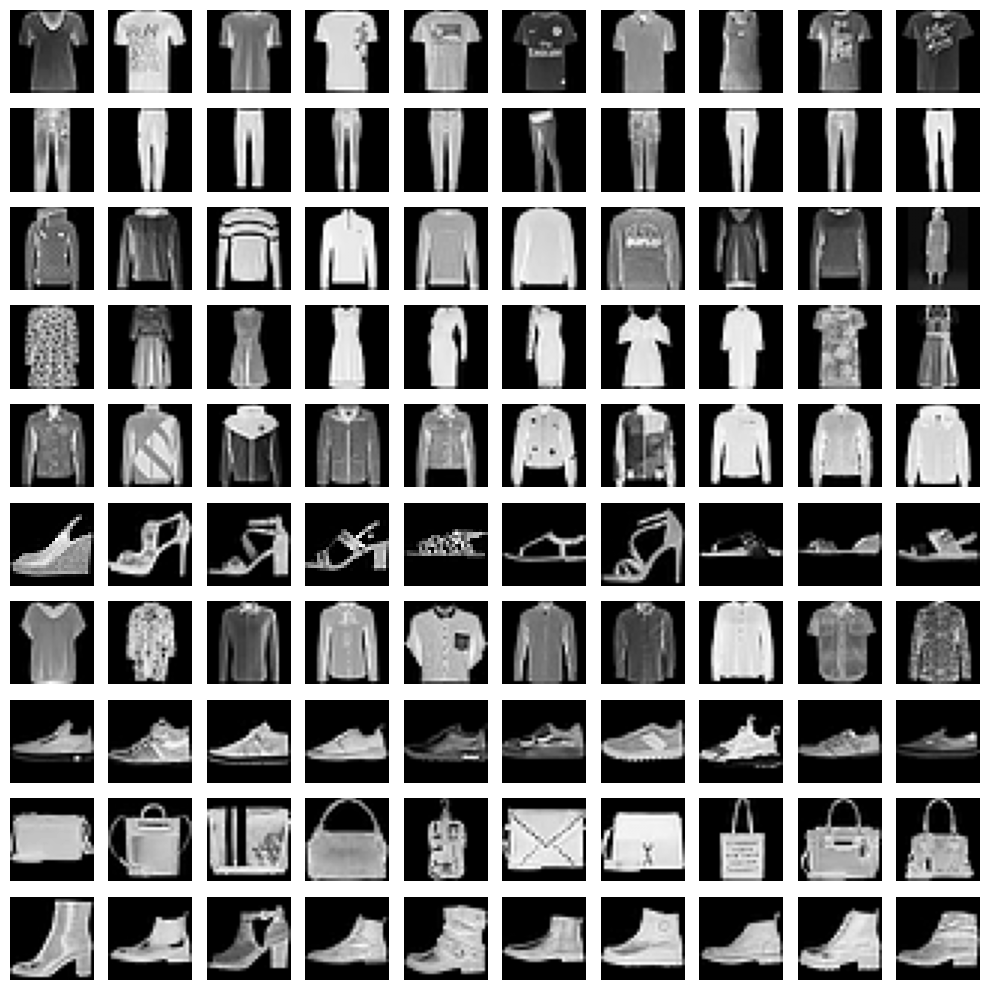

In [ ]:
row, column = len(train_img_targets.unique()), 10
fig, ax = plt.subplots(row, column, figsize=(10, 10))

for label_class, row_value in enumerate(ax):
    label_x_row = np.where(train_img_targets == label_class)[0]
    for plot_cell in row_value:
        plot_cell.grid(False)
        plot_cell.axis("off")
        rand_image_idx = np.random.choice(label_x_row)
        x = train_images[rand_image_idx]
        plot_cell.imshow(x, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:

class DatasetTransformer(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y

    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

def load_data():
    train_data = DatasetTransformer(train_images, train_img_targets)
    train_loaded_data = DataLoader(train_data, batch_size=32, shuffle=True)
    return train_loaded_data

from torch.optim import SGD

def run_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10),
    ).to(device)

    loss_fm = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    return model, loss_fm, optimizer

def trainer_each_batch(x, y, model, optimizer, loss_fm):
    model.train()
    prediction = model(x)
    loss_for_this_batch = loss_fm(prediction, y)
    loss_for_this_batch.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_for_this_batch.item()

In [ ]:
# Gradient example (for illustration)
x = torch.tensor([1., 2.], requires_grad=True)
print("original input", x)
y = 100 * x
loss = y.sum()
print(x.grad)
loss.backward()
print(x.grad)
optim = torch.optim.SGD([x], lr=0.001)
print(x)
optim.step()
print(x)

def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

training_data_loader = load_data()
model, loss_fm, optimizer = run_model()

losses, accuracies = [], []

for epoch in range(20):
    losses_in_this_epoch = []
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        loss_for_this_batch = trainer_each_batch(x, y, model, optimizer, loss_fm)
        losses_in_this_epoch.append(loss_for_this_batch)
    losses.append(np.mean(losses_in_this_epoch))

    with torch.no_grad():
        batch_accuracies = []
        for x, y in iter(training_data_loader):
            batch_accuracies.extend(accuracy(x, y, model))
        accuracy_this_epoch = np.mean(batch_accuracies)
        accuracies.append(accuracy_this_epoch)
    print(f"Epoch {epoch+1}: Loss {losses[-1]:.4f}, Accuracy {accuracies[-1]:.4f}")

original input tensor([1., 2.], requires_grad=True)
None
tensor([100., 100.])
tensor([1., 2.], requires_grad=True)
tensor([0.9000, 1.9000], requires_grad=True)
Epoch 1: Loss 1.3794, Accuracy 0.8240
Epoch 2: Loss 0.4073, Accuracy 0.8632
Epoch 3: Loss 0.3570, Accuracy 0.8767
Epoch 4: Loss 0.3274, Accuracy 0.8914
Epoch 5: Loss 0.3040, Accuracy 0.8996
Epoch 6: Loss 0.2876, Accuracy 0.9043
Epoch 7: Loss 0.2741, Accuracy 0.9065
Epoch 8: Loss 0.2598, Accuracy 0.9011
Epoch 9: Loss 0.2498, Accuracy 0.9179
Epoch 10: Loss 0.2404, Accuracy 0.9194
Epoch 11: Loss 0.2307, Accuracy 0.9242
Epoch 12: Loss 0.2224, Accuracy 0.9192
Epoch 13: Loss 0.2139, Accuracy 0.9290
Epoch 14: Loss 0.2082, Accuracy 0.9270
Epoch 15: Loss 0.2015, Accuracy 0.9228
Epoch 16: Loss 0.1949, Accuracy 0.9314
Epoch 17: Loss 0.1901, Accuracy 0.9290
Epoch 18: Loss 0.1869, Accuracy 0.9358
Epoch 19: Loss 0.1807, Accuracy 0.9414
Epoch 20: Loss 0.1751, Accuracy 0.9350


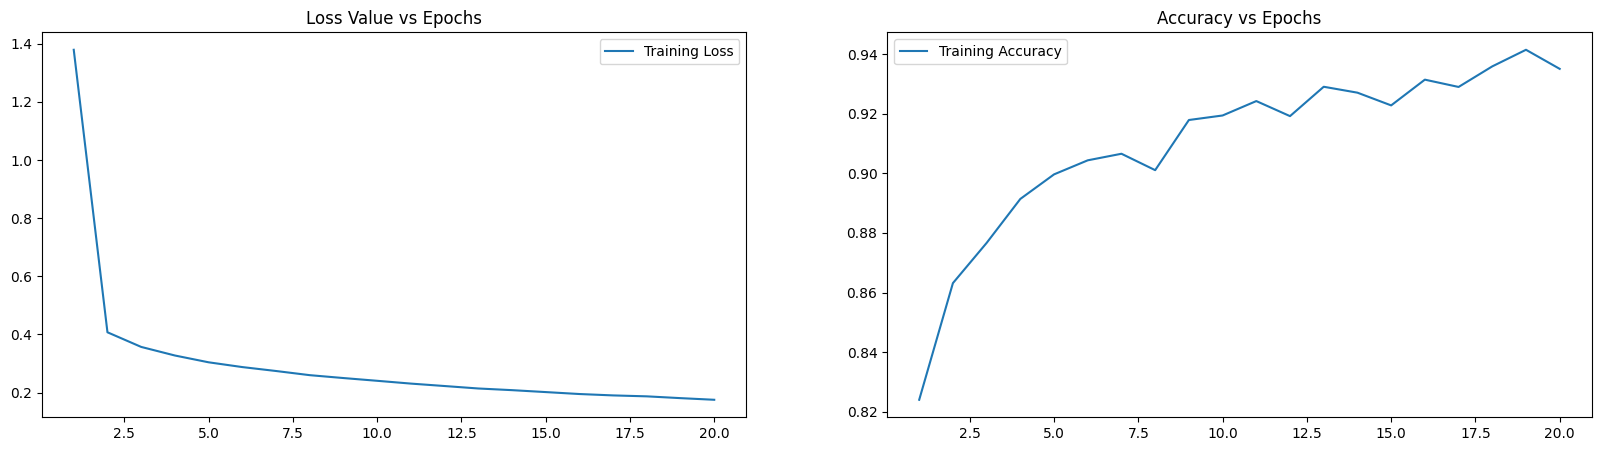

In [ ]:
epochs = np.arange(20) + 1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Loss Value vs Epochs")
plt.plot(epochs, losses, label="Training Loss")
plt.legend()

plt.subplot(122)
plt.title("Accuracy vs Epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.legend()
plt.show()

2.8.0+cpu
0.23.0+cpu


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.2MB/s]

img.size (28, 28)
label 0


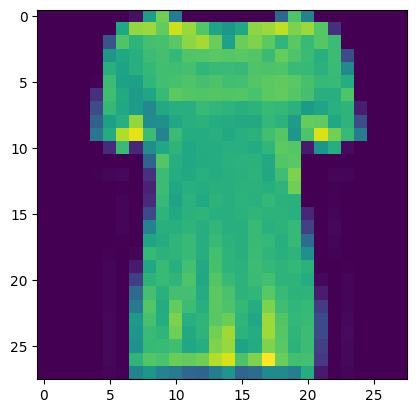

Train Image Shape torch.Size([60000, 28, 28])
Train Image Size torch.Size([60000, 28, 28])
Targets Shape torch.Size([60000])
Targets Size torch.Size([60000])


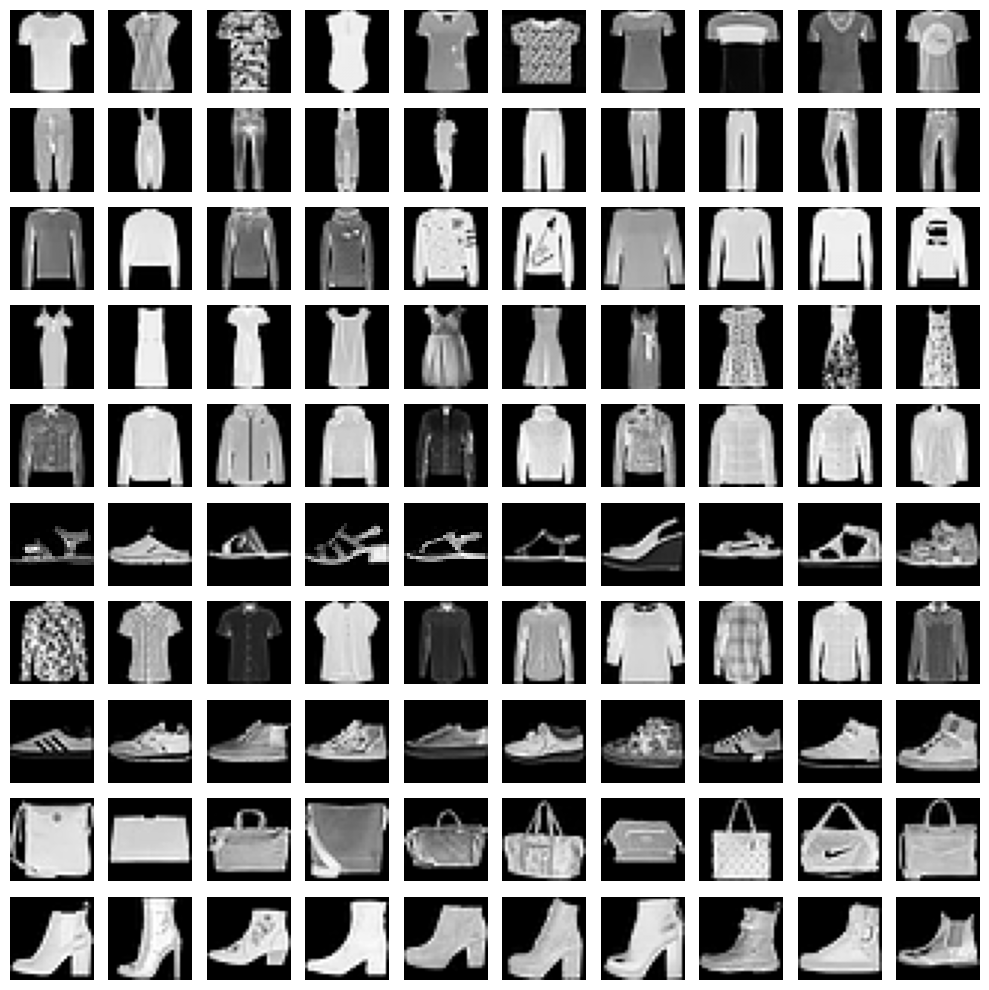

original input tensor([1., 2.], requires_grad=True)
None
tensor([100., 100.])
tensor([1., 2.], requires_grad=True)
tensor([0.9000, 1.9000], requires_grad=True)
Epoch 1: Loss 1.5213, Accuracy 0.8516
Epoch 2: Loss 0.4098, Accuracy 0.8578
Epoch 3: Loss 0.3597, Accuracy 0.8764
Epoch 4: Loss 0.3283, Accuracy 0.8889
Epoch 5: Loss 0.3092, Accuracy 0.8969


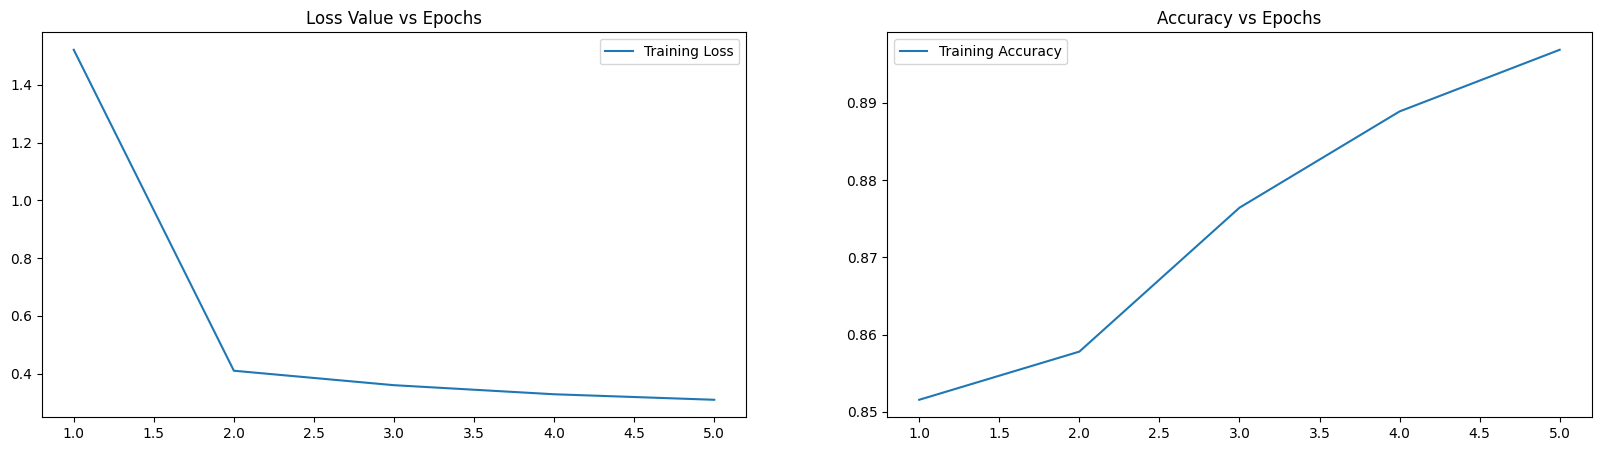

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
root_input_dataset_dir = "./input_dataset"

fmnist = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=True)
img, label = fmnist[10]
print("img.size", img.size)
print("label", label)
plt.imshow(img)
plt.show()

train_images = fmnist.data
train_img_targets = fmnist.targets

print("Train Image Shape", train_images.shape)
print("Train Image Size", train_images.size())
print("Targets Shape", train_img_targets.shape)
print("Targets Size", train_img_targets.size())

row, column = len(train_img_targets.unique()), 10
fig, ax = plt.subplots(row, column, figsize=(10, 10))

for label_class, row_value in enumerate(ax):
    label_x_row = np.where(train_img_targets == label_class)[0]
    for plot_cell in row_value:
        plot_cell.grid(False)
        plot_cell.axis("off")
        rand_image_idx = np.random.choice(label_x_row)
        x = train_images[rand_image_idx]
        plot_cell.imshow(x, cmap="gray")
plt.tight_layout()
plt.show()

class DatasetTransformer(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y

    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

def load_data():
    train_data = DatasetTransformer(train_images, train_img_targets)
    train_loaded_data = DataLoader(train_data, batch_size=32, shuffle=True)
    return train_loaded_data

from torch.optim import SGD

def run_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10),
    ).to(device)

    loss_fm = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    return model, loss_fm, optimizer

def trainer_each_batch(x, y, model, optimizer, loss_fm):
    model.train()
    prediction = model(x)
    loss_for_this_batch = loss_fm(prediction, y)
    loss_for_this_batch.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_for_this_batch.item()

# Gradient example (for illustration)
x = torch.tensor([1., 2.], requires_grad=True)
print("original input", x)
y = 100 * x
loss = y.sum()
print(x.grad)
loss.backward()
print(x.grad)
optim = torch.optim.SGD([x], lr=0.001)
print(x)
optim.step()
print(x)

def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

training_data_loader = load_data()
model, loss_fm, optimizer = run_model()

losses, accuracies = [], []

for epoch in range(5):
    losses_in_this_epoch = []
    for ix, batch in enumerate(iter(training_data_loader)):
        x, y = batch
        loss_for_this_batch = trainer_each_batch(x, y, model, optimizer, loss_fm)
        losses_in_this_epoch.append(loss_for_this_batch)
    losses.append(np.mean(losses_in_this_epoch))

    with torch.no_grad():
        batch_accuracies = []
        for x, y in iter(training_data_loader):
            batch_accuracies.extend(accuracy(x, y, model))
        accuracy_this_epoch = np.mean(batch_accuracies)
        accuracies.append(accuracy_this_epoch)
    print(f"Epoch {epoch+1}: Loss {losses[-1]:.4f}, Accuracy {accuracies[-1]:.4f}")

epochs = np.arange(5) + 1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Loss Value vs Epochs")
plt.plot(epochs, losses, label="Training Loss")
plt.legend()

plt.subplot(122)
plt.title("Accuracy vs Epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.legend()
plt.show()

In [ ]:
### DEEP NEURAL NETWORK WITH PYTORCH:

2.8.0+cu126
0.23.0+cu126
img.size (28, 28)
Label 9


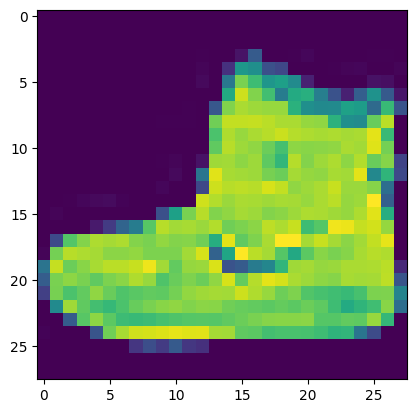

Train Images shape torch.Size([60000, 28, 28])
train_images_size torch.Size([60000, 28, 28])
Targets.shape torch.Size([60000])
Name of classes ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([28, 28])


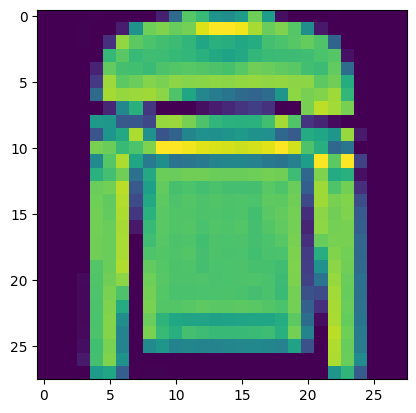

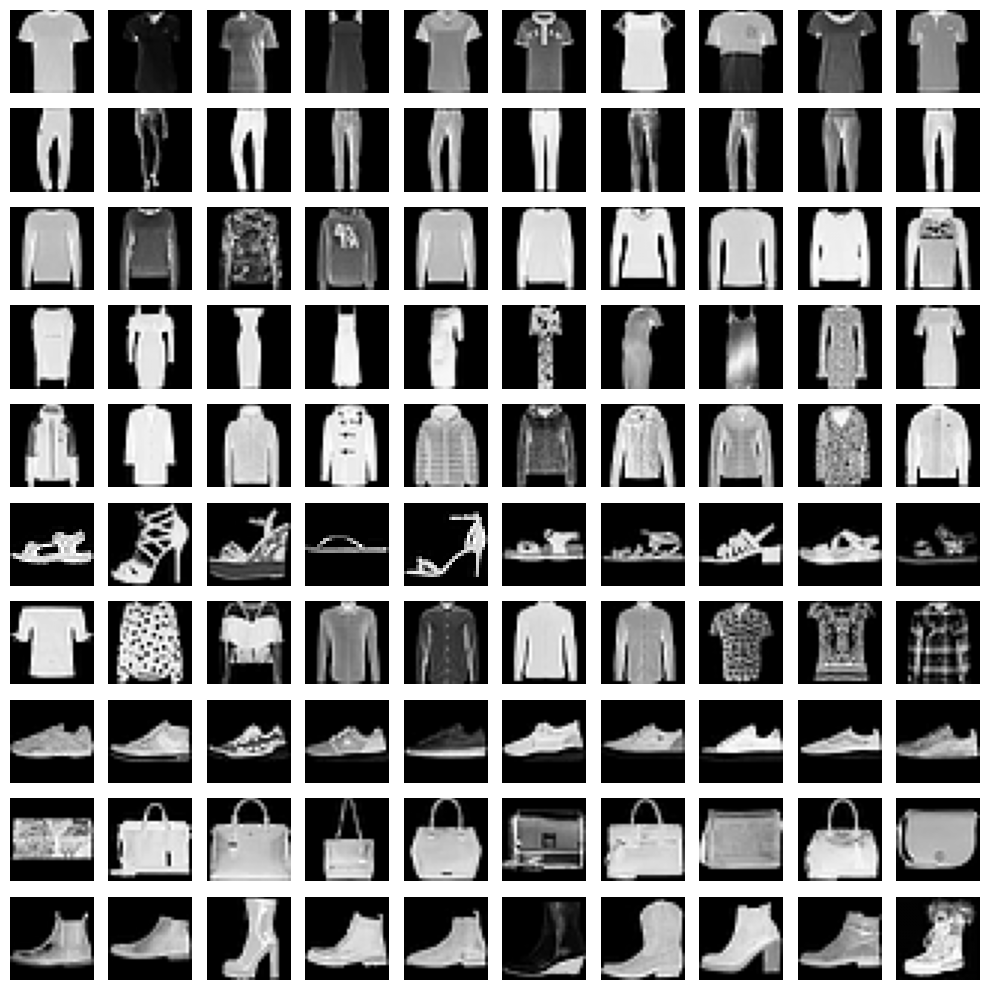

torch.Size([28, 28])


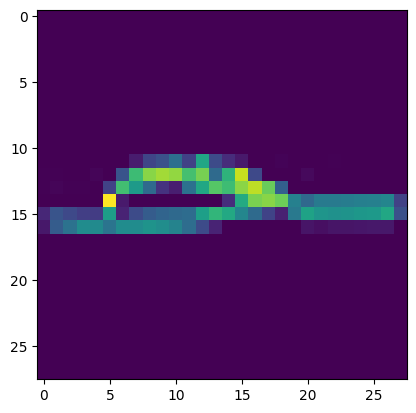

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


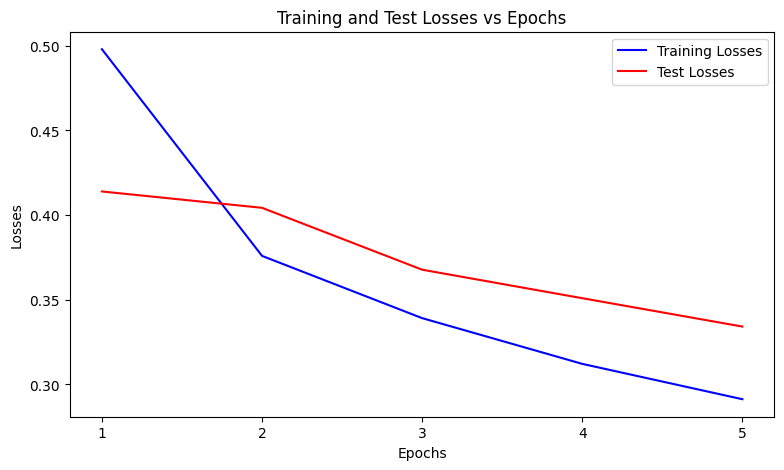

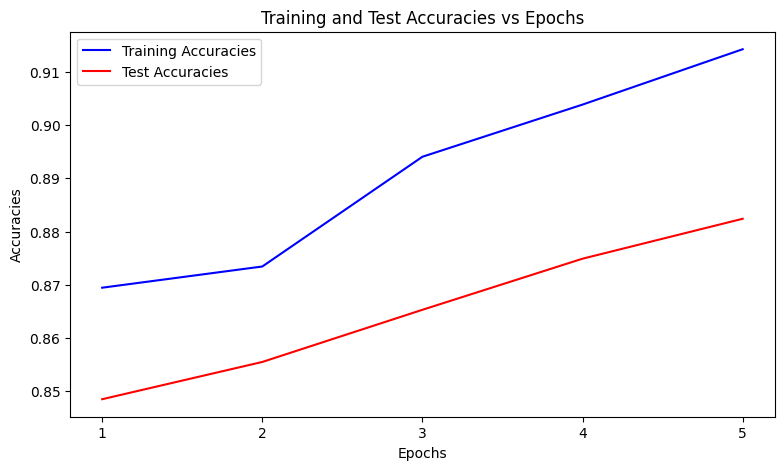

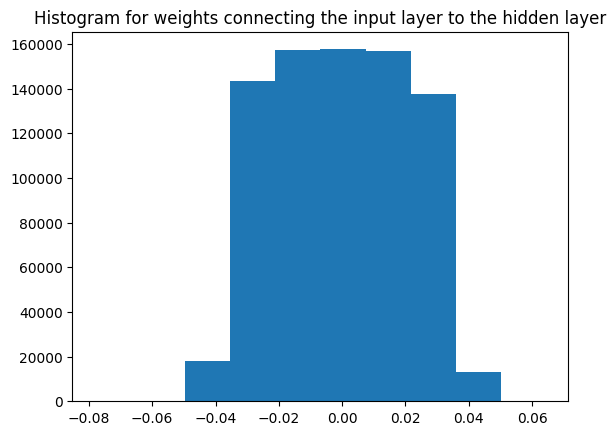

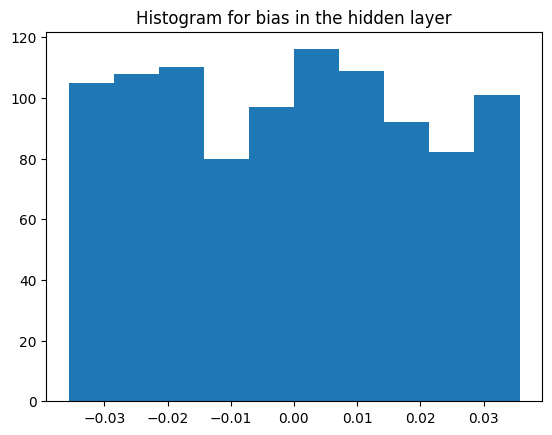

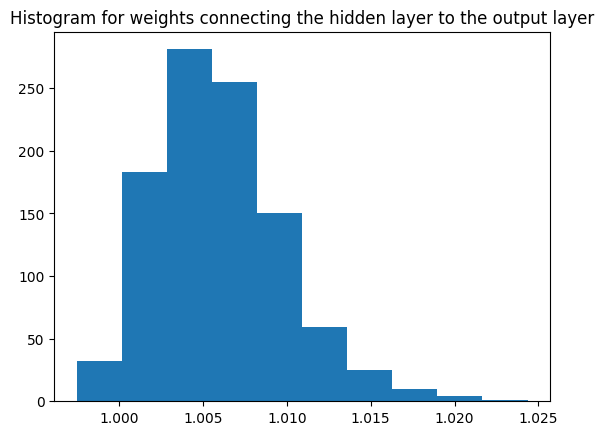

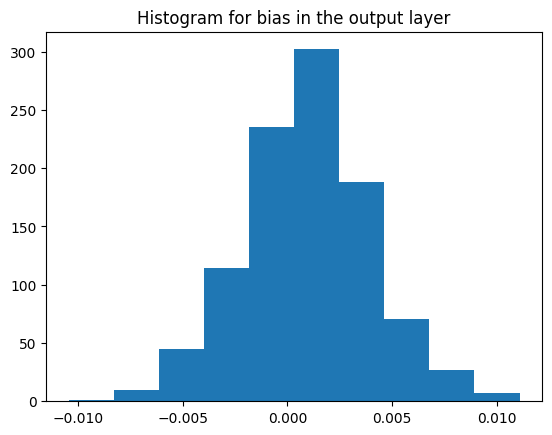

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

device = "cpu"

print(torch.__version__)
print(torchvision.__version__)

root_input_dataset_dir = "./input_dataset"

fmnist_train = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=True)

img, label = fmnist_train[0]
print("img.size", img.size)
print("Label", label)
plt.imshow(img)
plt.show()

train_images = fmnist_train.data
train_img_targets = fmnist_train.targets

print("Train Images shape", train_images.shape)
print("train_images_size", train_images.size())
print("Targets.shape", train_img_targets.shape)
print("Name of classes", fmnist_train.classes)

img = train_images[5]
print(img.size())
plt.imshow(img)
plt.show()

## Setting both row and column to be 10:
row, column = len(train_img_targets.unique()), 10

fig, ax = plt.subplots(row, column, figsize=(10, 10))

## As can be either a single Axes object or an array of Axes objects if more than one subplot was created:
## Here ax  is a 10 by 10 tuple (10, 10) ax.shape will give (10, 10)

for label_class, row_value in enumerate(ax):

  ## print(row_value)
  ## print("label_class", label_class)
  ## fetch the indices of rows (label x rows) corresponding to the given class number:

  label_x_rows = np.where(train_img_targets == label_class)[0]

  """
  Label_x_rows is an array of indices (corresponding to a given class) where train_img_targets == label_class
  np.where will return as an array, and I am selecting the very first element from that.
  Write that in the preceding code, we are fetching the 6th index asthe output of the np.where condition
  as it has a length of 1. It contains an array of all the indices where the target value (train_img_targets) is equal to label_class.
  """

  ## Loop through 10 times to fill the columns of a given row:
  for plot_cell in row_value:
    plot_cell.grid(False)
    plot_cell.axis("off")

    ## label_x_rows is an array of indices (corresponding to a given class) where train_img_targets == label_class.
    ## e.g label_x_rows == [1, 2, 4_ _ _ _ 58974 59985 59998]
    ## From tahat arraypick a single indices for plotting:
    rand_image_idx = np.random.choice(label_x_rows)
    x = train_images[rand_image_idx]
    plot_cell.imshow(x, cmap="gray")
plt.tight_layout()
plt.show()

fmnist_test = torchvision.datasets.FashionMNIST(root_input_dataset_dir, download=True, train=False)
test_images = fmnist_test.data
test_img_targets = fmnist_test.targets

random_test_img = test_images[8]
print(random_test_img.size())
plt.imshow(random_test_img)
plt.show()

class DatasetTransformer(Dataset):
  """ will take 2 arrays/tensors for parameters train_images (x) and train_img_targets(y)"""

  def __init__(self, x, y):
    ## Converting the input into a floating.point number
    ## And also scale them to the range of [0, 1] by distributing by 255:
    x = x.float()/255

    ## Flattened each image into 28*28 = 784 (numeric_values):
    ## Where each numeric value correspondings to a pixel value:
    x = x.view(-1, 28 * 28)
    self.x, self.y = x,y

  ## __getitem__ function returns a sample from the dataset gives an index:
  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    ## It is necessary to  have both the model, and the data on the same device:
    ## Either CPU or GPU, for the model to process data
    ## Data on CPU and model on CPU, or vice_versa. will result in a Runtime error
    ## to(device) == this method will move the tensor or model is the specified device
    return x.to(device), y.to(device)

  ## __len__function which returns the size of the dataset.
  def __len__(self):
    return len(self.x)

def load_data():
  ## Load Train Data:
  train_data = DatasetTransformer(train_images, train_img_targets)
  train_loaded_data = DataLoader(train_data, batch_size=32, shuffle=True)

  ## Load Test Data:
  test_data = DatasetTransformer(test_images, test_img_targets)
  test_loaded_data = DataLoader(test_data, batch_size=len(test_images), shuffle=False)

  return train_loaded_data, test_loaded_data

from torch.optim import SGD

def run_model():
  class neuralnetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.input_to_hidden_layer = nn.Linear(784, 1000)
      self.batch_more = nn.BatchNorm1d(1000)
      self.hidden_layer_activation = nn.ReLU()
      self.hidden_to_output_layer = nn.Linear(1000, 10)

    def forward(self, x):
      fc = self.input_to_hidden_layer(x)
      fc0 = self.batch_more(fc)
      fc1 = self.hidden_layer_activation(fc0)
      fc2 = self.hidden_to_output_layer(fc1)
      return fc2, fc1

  model = neuralnetwork().to(device)
  loss_fm = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=0.01)
  return model, loss_fm, optimizer

@torch.no_grad()
def test_loss(x, y, model, loss_fm):
  prediction = model(x)[0]
  test_loss = loss_fm(prediction, y)
  return test_loss.item()

def trainer_each_batch(x, y, model, optimizer, loss_fm):
  model.train()

  ## call model on the batch of inputs:
  ## "model.train()" sells your model that you are training the model:
  ## So BatchNorm layesr use per batch statistics and Dropout layers are activated etc:
  ## Forward pass: Compute predicted y by passing x to the model:

  prediction = model(x)[0]
  ## "prediction = model(x)" executes forward prepagation over x:

  ## compute loss:
  loss_for_this_batch = loss_fm(prediction, y)

  ## based on the forward pass in "mode(x)" compute all the gradients of model.parametrs():

  loss_for_this_batch.backward()
  ## loss.backward() computes dloss/dx for every paramater x which has requires_grad=True.
  ## These are accumulated into x.grid for every parameter x:
  ## In pseudo.code:
  ## x.grid += dloss/dx

  optimizer.step()

  optimizer.zero_grad()

  return loss_for_this_batch.item()

"""torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won't be able to backprop
(which you don't want in an eval script).
So torch.no_grad() basically skips the gradient calculation over the weights. That means you are not changing any weight in the specified layers.

if you are training pre-trained model, it's ok to use torch.no_grad() on all the layers except fully connected layer or classifier layer.
""" # Added closing triple quotes

@torch.no_grad()

def accuracy(x, y, model):

  ## model.eval() will notify all your layers that you are in eval mode:
  ## that way, batchnorm or dropout layers will work in eval mode instead of training mode:
  model.eval()

  ## get the prediction matrix for a tensor of "x" images:
  prediction = model(x)[0]

  ## Now compute if the location of maximum in each row coincides with ground truth:
  ## For that first, I am identifying the argmax index corresponding to each row with prediction.max[-1]:
  max_values, argmaxes = prediction.max(-1)

  """ Comparing argmaxes with the the ground truth through with argmaxes == y
  to check that each row is predicted correctly:"""

  is_correct = argmaxes == y

  return is_correct.cpu().numpy().tolist()

training_data_loader, test_loaded_data = load_data()
model, loss_fm, optimizer = run_model()


train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(5):
  print(f"Epoch {epoch+1}")

  ## Creating lists that will contain the accuracy and loss values corresponding to each batch within as epoch:
  losses_in_this_epoch, accuracies_in_this_epoch = [], []

  ## Create batches of training data by iterating through the DataLoader:
  for ix, batch in enumerate(iter(training_data_loader)):
      x, y = batch
      loss_for_this_batch = trainer_each_batch(x, y, model, optimizer, loss_fm)
      losses_in_this_epoch.append(loss_for_this_batch)

  ## After the above loop is done:
  ## Store the mean loss value across all batches within an epoch:
  epoch_loss = np.mean(losses_in_this_epoch)

  ## Iteration to calculate train_accuracies:
  ## Store the mean loss value across all batches within an epoch:
  for ix, batch in enumerate(iter(training_data_loader)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    accuracies_in_this_epoch.extend(is_correct)
  epoch_accuracy = np.mean(accuracies_in_this_epoch)

  for ix, batch in enumerate(iter(test_loaded_data)):
    x, y = batch
    test_is_correct = accuracy(x, y, model)
    test_epoch_loss = test_loss(x, y, model, loss_fm)

  test_epoch_accuracy = np.mean(test_is_correct)
  train_losses.append(epoch_loss)

  train_accuracies.append(epoch_accuracy)

  test_losses.append(test_epoch_loss)
  test_accuracies.append(test_epoch_accuracy)


import matplotlib.ticker as mticker

epochs = np.arange(5) + 1
plt.figure(figsize=(20, 5))
plt.subplot(121)

plt.plot(epochs, train_losses, "blue", label="Training Losses")
plt.plot(epochs, test_losses, "r", label="Test Losses")

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and Test Losses vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.grid(False)
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(epochs, train_accuracies, "blue", label="Training Accuracies")
plt.plot(epochs, test_accuracies, "r", label="Test Accuracies")

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.title("Training and Test Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()
plt.grid(False)
plt.show()


for ix, par in enumerate(model.parameters()):
  if(ix==0):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for weights connecting the input layer to the hidden layer")
    plt.show()
  if(ix==1):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for bias in the hidden layer")
    plt.show()
  if(ix==2):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for weights connecting the hidden layer to the output layer")
    plt.show()
  if(ix==3):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title("Histogram for bias in the output layer")
    plt.show()

PYTORCH ON DRONE DATASET.

In [ ]:
##barackdaud
##5a16387ff66a9d119277f086248c783f

In [ ]:
# ==============================================
# INSTALL & IMPORT DEPENDENCIES
# ==============================================
!pip install opendatasets --quiet
!pip install segmentation-models-pytorch albumentations torch torchvision --quiet


import opendatasets as od
od.download("https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset")

import os
import time
import cv2
import importlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import isfile, join
from os import listdir
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import albumentations as A
import segmentation_models_pytorch as smp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.7 MB/s eta 0:00:00
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: barackdaud
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset


100%|██████████| 3.89G/3.89G [00:55<00:00, 75.6MB/s]


In [ ]:

# ==============================================
# DEVICE CONFIGURATION
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 23

In [ ]:
import os

for root, dirs, files in os.walk("./semantic-drone-dataset", topdown=True):
    print(root)
    for d in dirs:
        print("  DIR:", d)
    for f in files[:3]:
        print("  FILE:", f)
    break  # stop after first level

./semantic-drone-dataset
  DIR: RGB_color_image_masks
  DIR: dataset
  FILE: class_dict_seg.csv


In [ ]:
import os

for root, dirs, files in os.walk("./semantic-drone-dataset", topdown=True):
    print(root)
    for d in dirs:
        print("  DIR:", d)
    for f in files[:3]:
        print("  FILE:", f)
    break  # stop after first level
print("Inside ./semantic-drone-dataset/dataset:")
print(os.listdir("./semantic-drone-dataset/dataset")[:10])

print("\nInside ./semantic-drone-dataset/RGB_color_image_masks:")
print(os.listdir("./semantic-drone-dataset/RGB_color_image_masks")[:10])

image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"

# If you prefer to use the colorized masks instead:
# mask_dir = "./semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

# Load and verify
image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
mask_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_list)} images and {len(mask_list)} masks")

./semantic-drone-dataset
  DIR: RGB_color_image_masks
  DIR: dataset
  FILE: class_dict_seg.csv
Inside ./semantic-drone-dataset/dataset:
['semantic_drone_dataset']

Inside ./semantic-drone-dataset/RGB_color_image_masks:
['RGB_color_image_masks']
Found 400 images and 400 masks


In [ ]:
import os

print("Inside ./semantic-drone-dataset/dataset:")
print(os.listdir("./semantic-drone-dataset/dataset")[:10])

print("\nInside ./semantic-drone-dataset/RGB_color_image_masks:")
print(os.listdir("./semantic-drone-dataset/RGB_color_image_masks")[:10])

Inside ./semantic-drone-dataset/dataset:
['semantic_drone_dataset']

Inside ./semantic-drone-dataset/RGB_color_image_masks:
['RGB_color_image_masks']


In [ ]:
import os

image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"

# If you prefer to use the colorized masks instead:
# mask_dir = "./semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

# Load and verify
image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
mask_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_list)} images and {len(mask_list)} masks")

Found 400 images and 400 masks


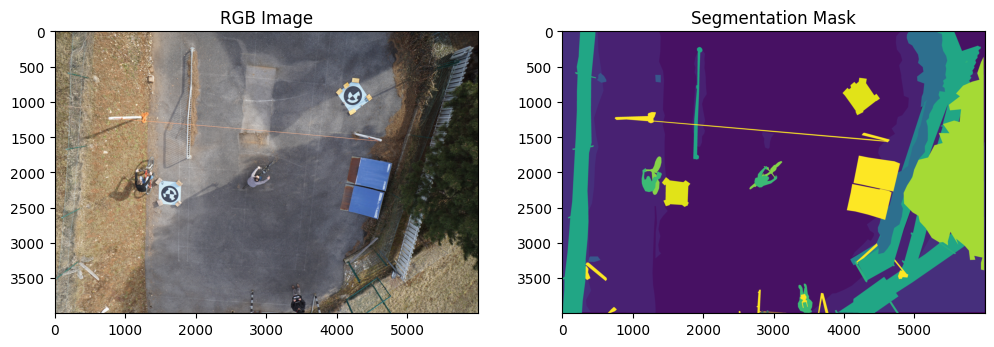

In [ ]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt

idx = 10
img = imageio.imread(image_list[idx])
mask = imageio.imread(mask_list[idx])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("RGB Image")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Segmentation Mask")
plt.show()

Found 400 images and 400 masks
Image shape: (4000, 6000, 3)
Mask shape: (4000, 6000)


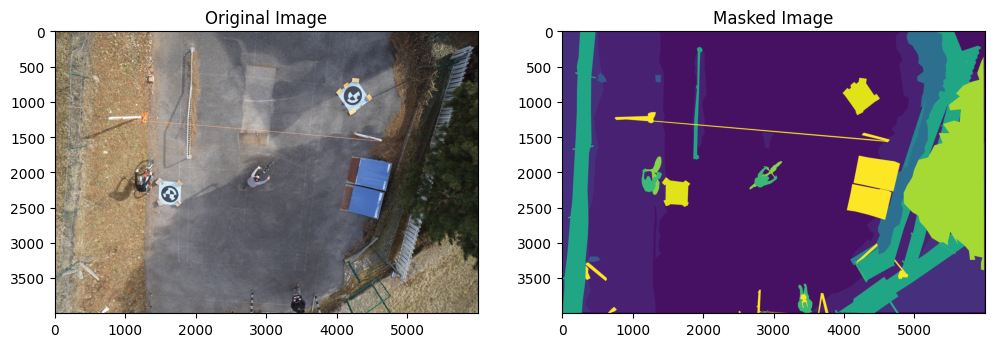

In [ ]:
# ==============================================
# DATA PREPARATION & VISUALIZATION (Fixed Paths)
# ==============================================

import os

image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"

# If you prefer to use the colorized masks instead:
# mask_dir = "./semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

# Load and verify
image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
mask_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_list)} images and {len(mask_list)} masks")

# Preview one image–mask pair
import imageio.v2 as imageio  # ensures compatibility
idx = 10  # choose an index
img = imageio.imread(image_list[idx])
mask = imageio.imread(mask_list[idx])

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(12, 10))
arr[0].imshow(img)
arr[0].set_title("Original Image")
arr[1].imshow(mask)
arr[1].set_title("Masked Image")
plt.show()

In [ ]:

# ==============================================
# HELPER FUNCTIONS
# ==============================================
def get_image_id_df(root_img_path):
    """
    Generate a DataFrame containing the image IDs.
    """
    filenames = [f for f in listdir(root_img_path) if isfile(join(root_img_path, f))]
    names = [filename.split(".")[0] for filename in filenames]
    return pd.DataFrame({"id": names}, index=np.arange(0, len(names)))


def pixel_accuracy(predicted_image, mask):
    """
    Calculate pixel accuracy between predicted and ground truth masks.
    """
    with torch.no_grad():
        predicted_image = torch.argmax(F.softmax(predicted_image, dim=1), dim=1)
        correct = torch.eq(predicted_image, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def mean_iou(predicted_label, label, eps=1e-10, num_classes=10):
    """
    Calculate mean Intersection over Union (IoU) between predictions and labels.
    """
    with torch.no_grad():
        predicted_label = F.softmax(predicted_label, dim=1)
        predicted_label = torch.argmax(predicted_label, dim=1)

        predicted_label = predicted_label.contiguous().view(-1)
        label = label.contiguous().view(-1)

        iou_single_class = []
        for class_number in range(num_classes):
            true_pred = predicted_label == class_number
            true_label = label == class_number

            if true_label.long().sum().item() == 0:
                iou_single_class.append(np.nan)
            else:
                intersection = torch.logical_and(true_pred, true_label).sum().float().item()
                union = torch.logical_or(true_pred, true_label).sum().float().item()
                iou_single_class.append((intersection + eps) / (union + eps))

        return np.nanmean(iou_single_class)

In [ ]:

# ==============================================
# PLOTTING FUNCTIONS
# ==============================================
def plot_loss_vs_epoch(history):
    plt.plot(history["val_loss"], label="Validation Loss", marker="o")
    plt.plot(history["train_loss"], label="Training Loss", marker="o")
    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


def plot_iou_score_vs_epoch(history):
    plt.plot(history["train_miou"], label="Train mIoU", marker="*")
    plt.plot(history["val_iou"], label="Validation mIoU", marker="*")
    plt.title("Mean IoU per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Mean IoU")
    plt.legend()
    plt.show()


def plot_accuracy_vs_epoch(history):
    plt.plot(history["train_acc"], label="Train Accuracy", marker="*")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="*")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:

# ==============================================
# PREDICTION & EVALUATION FUNCTIONS
# ==============================================
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = transform(image).to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        pred = model(image)
        mean_iou_score = mean_iou(pred, mask)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)

    return masked, mean_iou_score


def predict_image_mask_pixel_accuracy(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = transform(image).to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        pred = model(image)
        acc = pixel_accuracy(pred, mask)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)

    return masked, acc


def miou_score_from_trained_model(model, test_set):
    scores = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, score = predict_image_mask_miou(model, img, mask)
        scores.append(score)
    return scores


def pixel_accuracy_from_trained_model(model, test_set):
    accuracies = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, acc = predict_image_mask_pixel_accuracy(model, img, mask)
        accuracies.append(acc)
    return accuracies

In [ ]:

# ==============================================
# TRAINING UTILITIES
# ==============================================
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    history = {
        "train_loss": [], "val_loss": [],
        "train_miou": [], "val_iou": [],
        "train_acc": [], "val_acc": [],
        "lrs": []
    }

    model.to(device)
    fit_time = time.time()
    min_loss = np.inf
    decreases = 1
    patience = 0

    for epoch in range(epochs):
        start_time = time.time()
        running_loss, iou_score, accuracy = 0, 0, 0

        # Training
        model.train()
        for image_tiles, mask_tiles in tqdm(train_loader):
            if patch:
                b, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image, mask = image_tiles.to(device), mask_tiles.to(device)
            pred = model(image)
            loss = criterion(pred, mask)

            iou_score += mean_iou(pred, mask)
            accuracy += pixel_accuracy(pred, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            history["lrs"].append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        test_loss, test_acc, val_iou_score = 0, 0, 0
        with torch.no_grad():
            for image_tiles, mask_tiles in tqdm(val_loader):
                if patch:
                    b, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)

                image, mask = image_tiles.to(device), mask_tiles.to(device)
                pred = model(image)
                val_iou_score += mean_iou(pred, mask)
                test_acc += pixel_accuracy(pred, mask)
                test_loss += criterion(pred, mask).item()

        # Metrics
        train_loss = running_loss / len(train_loader)
        val_loss = test_loss / len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_miou"].append(iou_score / len(train_loader))
        history["train_acc"].append(accuracy / len(train_loader))
        history["val_iou"].append(val_iou_score / len(val_loader))
        history["val_acc"].append(test_acc / len(val_loader))

        # Logging
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | "
            f"Train mIoU: {iou_score/len(train_loader):.3f} | Val mIoU: {val_iou_score/len(val_loader):.3f} | "
            f"Train Acc: {accuracy/len(train_loader):.3f} | Val Acc: {test_acc/len(val_loader):.3f} | "
            f"Time: {(time.time()-start_time)/60:.2f}m"
        )

        if val_loss < min_loss:
            print(f"Loss Decreasing... {min_loss:.3f} >> {val_loss:.3f}")
            min_loss = val_loss
            decreases += 1
            patience = 0
            if decreases % 5 == 0:
                torch.save(model, f"Inception-v4_mIoU-{val_iou_score/len(val_loader):.3f}.pt")
                print("Model saved.")
        else:
            patience += 1
            print(f"Loss not decreasing for {patience} epochs.")
            if patience >= 6:
                print("Early stopping.")
                break

    print(f"Total training time: {(time.time()-fit_time)/60:.2f}m")
    return history

In [ ]:
# ==============================================
# DATASET CLASSES
# ==============================================
class DataGen(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patches = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(join(self.img_path, self.X[idx] + ".jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(join(self.mask_path, self.X[idx] + ".png"), cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(augmented["image"]), augmented["mask"]
        else:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.get_img_patches(img, mask)

        return img, mask

    def get_img_patches(self, img, mask):
        kh, kw = 512, 768
        dh, dw = 512, 768
        img_patches = img.unfold(1, kh, dh).unfold(2, kw, dw)
        img_patches = img_patches.contiguous().view(3, -1, kh, kw).permute(1, 0, 2, 3)
        mask_patches = mask.unfold(0, kh, dh).unfold(1, kw, dw)
        mask_patches = mask_patches.contiguous().view(-1, kh, kw)
        return img_patches, mask_patches


class TestDataGen(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + ".png", cv2.IMREAD_GRAYSCALE)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(aug["image"]), aug["mask"]
        else:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()
        return img, mask

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: barackdaud
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset


100%|██████████| 3.89G/3.89G [00:45<00:00, 91.4MB/s]



Test set contains 40 images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

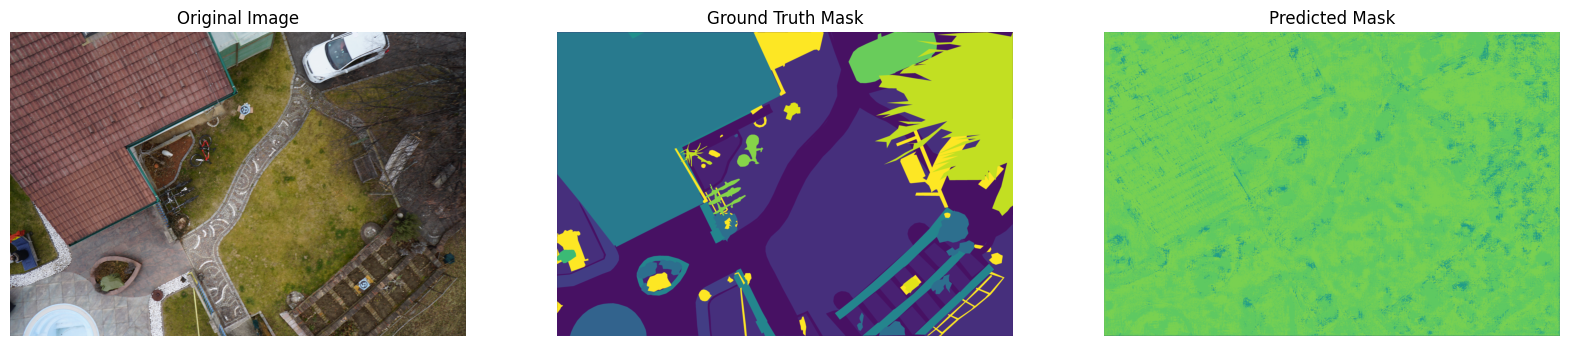

In [ ]:
# ==============================================
# INSTALL & IMPORT DEPENDENCIES
# ==============================================
!pip install opendatasets --quiet
!pip install segmentation-models-pytorch albumentations torch torchvision --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset")

import os, cv2, torch, numpy as np
from torch.utils.data import Dataset
from torchvision import transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from torch.nn import functional as F

# ==============================================
# DEVICE CONFIGURATION
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 23

# ==============================================
# HELPER FUNCTIONS
# ==============================================
def pixel_accuracy(predicted_image, mask):
    with torch.no_grad():
        predicted_image = torch.argmax(F.softmax(predicted_image, dim=1), dim=1)
        correct = torch.eq(predicted_image, mask).int()
        return float(correct.sum()) / float(correct.numel())

def mean_iou(predicted_label, label, eps=1e-10, num_classes=23):
    with torch.no_grad():
        predicted_label = torch.argmax(F.softmax(predicted_label, dim=1), dim=1)
        predicted_label = predicted_label.contiguous().view(-1)
        label = label.contiguous().view(-1)
        iou_per_class = []
        for c in range(num_classes):
            pred_c = predicted_label == c
            label_c = label == c
            if label_c.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersection = torch.logical_and(pred_c, label_c).sum().float().item()
                union = torch.logical_or(pred_c, label_c).sum().float().item()
                iou_per_class.append((intersection + eps) / (union + eps))
        return np.nanmean(iou_per_class)

def predict_image_mask(model, image, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    transform = T.Compose([T.ToTensor(), T.Normalize(mean,std)])
    img_tensor = transform(image).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(img_tensor)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)
    return masked

# ==============================================
# DATASET CLASSES
# ==============================================
class TestDataGen(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_path, self.X[idx]+".jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_path, self.X[idx]+".png"), cv2.IMREAD_GRAYSCALE)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(aug["image"]), aug["mask"]
        else:
            img = Image.fromarray(img)
        mask = torch.from_numpy(mask).long()
        return img, mask

# ==============================================
# PATHS & IMAGE IDS
# ==============================================
image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg",".png"))])
image_ids = [os.path.splitext(os.path.basename(f))[0] for f in image_list]

train_ids, test_ids = train_test_split(image_ids, test_size=0.1, random_state=42)
print(f"Test set contains {len(test_ids)} images")

# ==============================================
# CREATE TEST DATASET
# ==============================================
transform = A.Compose([])  # no augmentation for testing
test_set = TestDataGen(img_path=image_dir, mask_path=mask_dir, X=test_ids, transform=transform)

# ==============================================
# INITIALIZE MODEL
# ==============================================
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=n_classes
).to(device)

model.eval()

# ==============================================
# VISUALIZE SAMPLE PREDICTION
# ==============================================
sample_idx = 3
image, mask = test_set[sample_idx]
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,10))
ax1.imshow(image); ax1.set_title("Original Image"); ax1.axis('off')
ax2.imshow(mask); ax2.set_title("Ground Truth Mask"); ax2.axis('off')
ax3.imshow(pred_mask); ax3.set_title("Predicted Mask"); ax3.axis('off')
plt.show()


##barackdaud
##5a16387ff66a9d119277f086248c783f

Skipping, found downloaded files in "./semantic-drone-dataset" (use force=True to force download)
Test set contains 40 images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

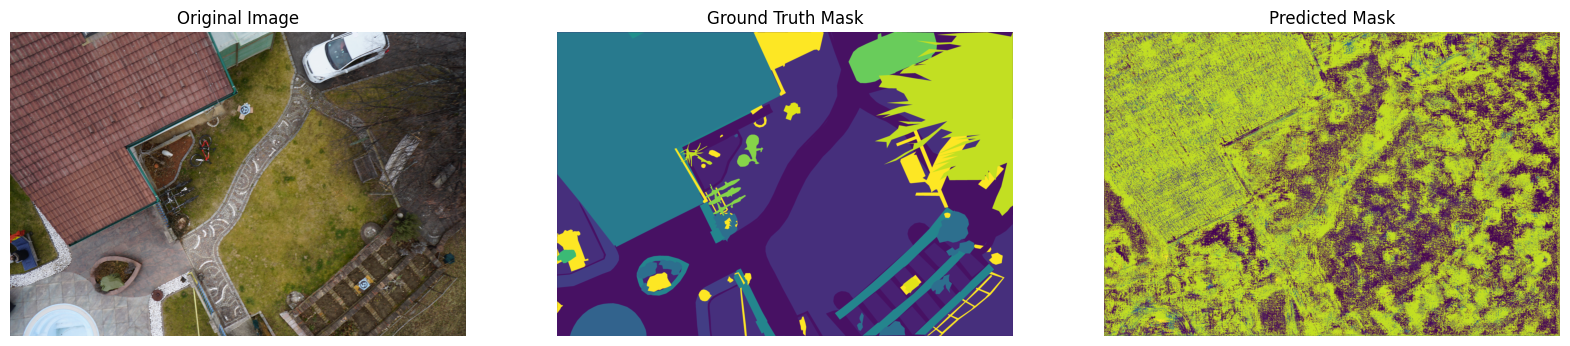

In [ ]:
# ==============================================
# INSTALL & IMPORT DEPENDENCIES
# ==============================================
!pip install opendatasets --quiet
!pip install segmentation-models-pytorch albumentations torch torchvision --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset")

import os, cv2, torch, numpy as np
from torch.utils.data import Dataset
from torchvision import transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# ==============================================
# DEVICE CONFIGURATION & CLASSES
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 23

class TestDataGen(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + ".png", cv2.IMREAD_GRAYSCALE)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(aug["image"]), aug["mask"]
        else:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()
        return img, mask

# ==============================================
# PATHS & IMAGE IDS
# ==============================================
image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
image_ids = [os.path.splitext(os.path.basename(f))[0] for f in image_list]

# Split train/test
train_ids, test_ids = train_test_split(image_ids, test_size=0.1, random_state=42)
print(f"Test set contains {len(test_ids)} images")

# ==============================================
# CREATE TEST DATASET
# ==============================================
transform = A.Compose([])  # no augmentation for testing
test_set = TestDataGen(img_path=image_dir, mask_path=mask_dir, X=test_ids, transform=transform)

# ==============================================
# INITIALIZE MODEL
# ==============================================
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=n_classes
).to(device)

model.eval()  # put model in evaluation mode

# ==============================================
# PREDICTION FUNCTION
# ==============================================
def predict_image_mask_miou(model, image, mask, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    model.eval()
    transform = T.Compose([T.ToTensor(), T.Normalize(mean,std)])
    image = transform(image).to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        pred = model(image)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)
    return masked

# ==============================================
# VISUALIZE SAMPLE
# ==============================================
sample_idx = 3
image, mask = test_set[sample_idx]
pred_mask = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title("Original Image"); ax1.axis('off')
ax2.imshow(mask)
ax2.set_title("Ground Truth Mask"); ax2.axis('off')
ax3.imshow(pred_mask)
ax3.set_title("Predicted Mask"); ax3.axis('off')
plt.show()

In [ ]:
##barackdaud
##5a16387ff66a9d119277f086248c783f

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle userna

100%|██████████| 3.89G/3.89G [00:16<00:00, 258MB/s]



./semantic-drone-dataset
  DIR: RGB_color_image_masks
  DIR: dataset
  FILE: class_dict_seg.csv
Inside ./semantic-drone-dataset/dataset:
['semantic_drone_dataset']

Inside ./semantic-drone-dataset/RGB_color_image_masks:
['RGB_color_image_masks']
Found 400 images and 400 masks
Found 400 images and 400 masks
Image shape: (4000, 6000, 3)
Mask shape: (4000, 6000)


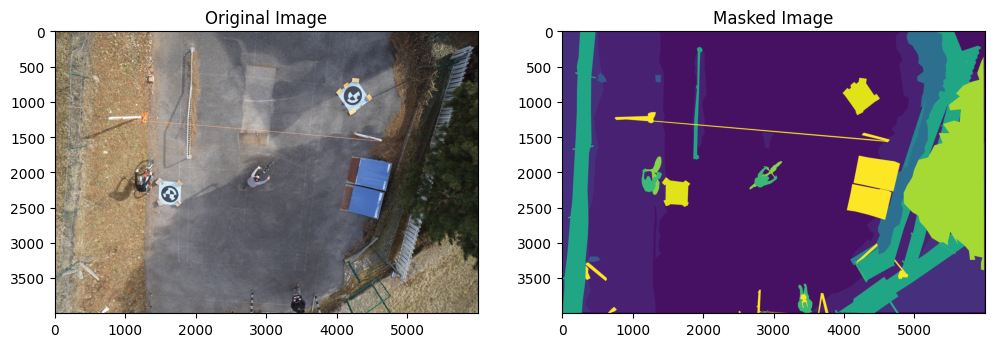

In [ ]:
# ==============================================
# INSTALL & IMPORT DEPENDENCIES
# ==============================================
!pip install opendatasets --quiet
!pip install segmentation-models-pytorch albumentations torch torchvision --quiet


import opendatasets as od
od.download("https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset")

import os
import time
import cv2
import importlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import isfile, join
from os import listdir
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import albumentations as A
import segmentation_models_pytorch as smp

# ==============================================
# DEVICE CONFIGURATION
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 23


for root, dirs, files in os.walk("./semantic-drone-dataset", topdown=True):
    print(root)
    for d in dirs:
        print("  DIR:", d)
    for f in files[:3]:
        print("  FILE:", f)
    break  # stop after first level
print("Inside ./semantic-drone-dataset/dataset:")
print(os.listdir("./semantic-drone-dataset/dataset")[:10])

print("\nInside ./semantic-drone-dataset/RGB_color_image_masks:")
print(os.listdir("./semantic-drone-dataset/RGB_color_image_masks")[:10])

image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"

# If you prefer to use the colorized masks instead:
# mask_dir = "./semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

# Load and verify
image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
mask_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_list)} images and {len(mask_list)} masks")



# ==============================================
# DATA PREPARATION & VISUALIZATION (Fixed Paths)
# ==============================================

import os

image_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
mask_dir = "./semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"

# If you prefer to use the colorized masks instead:
# mask_dir = "./semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

# Load and verify
image_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))])
mask_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith((".jpg", ".png"))])

print(f"Found {len(image_list)} images and {len(mask_list)} masks")

# Preview one image–mask pair
import imageio.v2 as imageio  # ensures compatibility
idx = 10  # choose an index
img = imageio.imread(image_list[idx])
mask = imageio.imread(mask_list[idx])

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(12, 10))
arr[0].imshow(img)
arr[0].set_title("Original Image")
arr[1].imshow(mask)
arr[1].set_title("Masked Image")

# ==============================================
# HELPER FUNCTIONS
# ==============================================
def get_image_id_df(root_img_path):
    """
    Generate a DataFrame containing the image IDs.
    """
    filenames = [f for f in listdir(root_img_path) if isfile(join(root_img_path, f))]
    names = [filename.split(".")[0] for filename in filenames]
    return pd.DataFrame({"id": names}, index=np.arange(0, len(names)))


def pixel_accuracy(predicted_image, mask):
    """
    Calculate pixel accuracy between predicted and ground truth masks.
    """
    with torch.no_grad():
        predicted_image = torch.argmax(F.softmax(predicted_image, dim=1), dim=1)
        correct = torch.eq(predicted_image, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def mean_iou(predicted_label, label, eps=1e-10, num_classes=10):
    """
    Calculate mean Intersection over Union (IoU) between predictions and labels.
    """
    with torch.no_grad():
        predicted_label = F.softmax(predicted_label, dim=1)
        predicted_label = torch.argmax(predicted_label, dim=1)

        predicted_label = predicted_label.contiguous().view(-1)
        label = label.contiguous().view(-1)

        iou_single_class = []
        for class_number in range(num_classes):
            true_pred = predicted_label == class_number
            true_label = label == class_number

            if true_label.long().sum().item() == 0:
                iou_single_class.append(np.nan)
            else:
                intersection = torch.logical_and(true_pred, true_label).sum().float().item()
                union = torch.logical_or(true_pred, true_label).sum().float().item()
                iou_single_class.append((intersection + eps) / (union + eps))

        return np.nanmean(iou_single_class)


# ==============================================
# PLOTTING FUNCTIONS
# ==============================================
def plot_loss_vs_epoch(history):
    plt.plot(history["val_loss"], label="Validation Loss", marker="o")
    plt.plot(history["train_loss"], label="Training Loss", marker="o")
    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


def plot_iou_score_vs_epoch(history):
    plt.plot(history["train_miou"], label="Train mIoU", marker="*")
    plt.plot(history["val_iou"], label="Validation mIoU", marker="*")
    plt.title("Mean IoU per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Mean IoU")
    plt.legend()
    plt.show()


def plot_accuracy_vs_epoch(history):
    plt.plot(history["train_acc"], label="Train Accuracy", marker="*")
    plt.plot(history["val_acc"], label="Validation Accuracy", marker="*")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


# ==============================================
# PREDICTION & EVALUATION FUNCTIONS
# ==============================================
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = transform(image).to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        pred = model(image)
        mean_iou_score = mean_iou(pred, mask)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)

    return masked, mean_iou_score


def predict_image_mask_pixel_accuracy(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = transform(image).to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        pred = model(image)
        acc = pixel_accuracy(pred, mask)
        masked = torch.argmax(pred, dim=1).cpu().squeeze(0)

    return masked, acc


def miou_score_from_trained_model(model, test_set):
    scores = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, score = predict_image_mask_miou(model, img, mask)
        scores.append(score)
    return scores


def pixel_accuracy_from_trained_model(model, test_set):
    accuracies = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        _, acc = predict_image_mask_pixel_accuracy(model, img, mask)
        accuracies.append(acc)
    return accuracies


# ==============================================
# TRAINING UTILITIES
# ==============================================
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    history = {
        "train_loss": [], "val_loss": [],
        "train_miou": [], "val_iou": [],
        "train_acc": [], "val_acc": [],
        "lrs": []
    }

    model.to(device)
    fit_time = time.time()
    min_loss = np.inf
    decreases = 1
    patience = 0

    for epoch in range(epochs):
        start_time = time.time()
        running_loss, iou_score, accuracy = 0, 0, 0

        # Training
        model.train()
        for image_tiles, mask_tiles in tqdm(train_loader):
            if patch:
                b, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image, mask = image_tiles.to(device), mask_tiles.to(device)
            pred = model(image)
            loss = criterion(pred, mask)

            iou_score += mean_iou(pred, mask)
            accuracy += pixel_accuracy(pred, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            history["lrs"].append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        test_loss, test_acc, val_iou_score = 0, 0, 0
        with torch.no_grad():
            for image_tiles, mask_tiles in tqdm(val_loader):
                if patch:
                    b, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)

                image, mask = image_tiles.to(device), mask_tiles.to(device)
                pred = model(image)
                val_iou_score += mean_iou(pred, mask)
                test_acc += pixel_accuracy(pred, mask)
                test_loss += criterion(pred, mask).item()

        # Metrics
        train_loss = running_loss / len(train_loader)
        val_loss = test_loss / len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_miou"].append(iou_score / len(train_loader))
        history["train_acc"].append(accuracy / len(train_loader))
        history["val_iou"].append(val_iou_score / len(val_loader))
        history["val_acc"].append(test_acc / len(val_loader))

        # Logging
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | "
            f"Train mIoU: {iou_score/len(train_loader):.3f} | Val mIoU: {val_iou_score/len(val_loader):.3f} | "
            f"Train Acc: {accuracy/len(train_loader):.3f} | Val Acc: {test_acc/len(val_loader):.3f} | "
            f"Time: {(time.time()-start_time)/60:.2f}m"
        )

        if val_loss < min_loss:
            print(f"Loss Decreasing... {min_loss:.3f} >> {val_loss:.3f}")
            min_loss = val_loss
            decreases += 1
            patience = 0
            if decreases % 5 == 0:
                torch.save(model, f"Inception-v4_mIoU-{val_iou_score/len(val_loader):.3f}.pt")
                print("Model saved.")
        else:
            patience += 1
            print(f"Loss not decreasing for {patience} epochs.")
            if patience >= 6:
                print("Early stopping.")
                break

    print(f"Total training time: {(time.time()-fit_time)/60:.2f}m")
    return history


# ==============================================
# DATASET CLASSES
# ==============================================
class DataGen(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patches = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(join(self.img_path, self.X[idx] + ".jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(join(self.mask_path, self.X[idx] + ".png"), cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(augmented["image"]), augmented["mask"]
        else:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.get_img_patches(img, mask)

        return img, mask

    def get_img_patches(self, img, mask):
        kh, kw = 512, 768
        dh, dw = 512, 768
        img_patches = img.unfold(1, kh, dh).unfold(2, kw, dw)
        img_patches = img_patches.contiguous().view(3, -1, kh, kw).permute(1, 0, 2, 3)
        mask_patches = mask.unfold(0, kh, dh).unfold(1, kw, dw)
        mask_patches = mask_patches.contiguous().view(-1, kh, kw)
        return img_patches, mask_patches


class TestDataGen(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + ".jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + ".png", cv2.IMREAD_GRAYSCALE)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = Image.fromarray(aug["image"]), aug["mask"]
        else:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()
        return img, mask